In [1]:
#those are the python packages you need
import numpy as np
import pandas as pd
#import FortitudeRe as frl
import random
import statistics
import csv
import time
import QuantLib as ql 

In [2]:
dayCount=ql.ActualActual()
calendar = ql.UnitedStates()
interpolation = ql.Linear()
compounding = ql.Compounded

## Gradient Algorithm and helper class 

In [3]:
#those are the 2 classes you need 
class cashFlowObj:
    def __init__(self):
        self.isin='abc'
        self.isGrouped=False
        self.mvLcl=0
        self.mvUsd=0
        self.cashFlowsUsdCurrent=pd.Series()
        self.weight=1
        self.issueDate='1900-01-01'
        self.derivative=0
       
def gradientSolver(assetList,liability,nbIter,flatDiscount,halfRate=50,minLearnRate=0.01,learningRate=1,randomize=False):
#Gradient descent function that outputs a dictionary of asset identifier=key and weight of the asset +cost function over time
#this function assumes a sum of square as the cost function
#quite many more variations could be made but this one is fun :)

#sum CF per year
    total=pd.Series()
    alm=pd.Series()
    learningRate=learningRate
    costF=[]
    nbiter=nbIter
    decay=2
    statsL=[]
    if randomize==True:
        for asset in assetList:
            asset.weight=0.001
            
    for itera in range(nbiter):
        if itera%halfRate==0:
            learningRate=max(learningRate/decay,minLearnRate)
        #learningRate=learningRate*decay
        #sum up all cf per time period
        #calculate total CF there 
        for item in assetList: #there is a better way than loop but its easier to understand
            total=total.add(item.cashFlowsUsdCurrent*item.weight,fill_value=0)

        #asset minus liabilities
        alm=alm.add(total,fill_value=0) #add assets
        
        alm=alm.add(-liability.cashFlowsUsdCurrent,fill_value=0) #add liabilities

        #derivative sumOfSquare
        normD=0

        #normalize the derivatives
        for item in assetList:
            #item.derivative= pd.Series(alm*item.cashFlowsUsdCurrent).sum()
            item.derivative=np.npv(flatDiscount,alm*item.cashFlowsUsdCurrent)
            #statsL.append(pd.Series(alm*item.cashFlowsUsdCurrent).sum())
            statsL.append(item.derivative)
        std=statistics.stdev(statsL)
        mean=statistics.mean(statsL)
        

        for item in assetList:
            #calculate derivative according to a sum of square minimization
                #item.derivative= pd.Series(alm*item.cashFlowsUsdCurrent).sum()
                #item.derivative=item.derivative/std
                #print(item.derivative/normD)
                item.weight=item.weight-learningRate*((item.derivative)/std)
                #item.weight=max(min(item.weight,1),0)
                #item.weight=max(min(1,item.weight),0)
                item.cashFlowsUsdCurrent=item.cashFlowsUsdCurrent
    #reset to 0
        #costF.append(pd.Series.sum(alm**2))
        costF.append(np.npv(flatDiscount,alm**2))
        alm=alm*0
        total=total*0
        statsL.clear()
    isinWeight={item.isin:item.weight for item in assetList}
    return isinWeight,costF

## Bogus Liability

In [4]:
#pick up the liability
iniAlm=pd.Series()
a=np.ones(30)*0.9
a=a.cumprod()+np.random.sample(30)/7 
    
a=a*140000000

#df2=pd.read_excel(path,sheet_name='Liability')
liability=cashFlowObj()
#liability.cashFlowsUsdCurrent=pd.Series(df2['Liability'].copy())
liability.cashFlowsUsdCurrent=pd.Series(a)
#Just to see the original ALM


## Bogus Asset cash flows list 

In [6]:

assetList=[]


#bogus assets
for i in range(0,250):
    faceAmount=random.randint(10,25)*100000*3**random.randint(1,2)
    coupon=random.randint(30, 50)/1000
    asset=cashFlowObj()
    asset.isin='bogus'+str(i)
    maturity=random.randint(0,31)
    asset.cashFlowsUsdCurrent=pd.Series(np.zeros(90))
    asset.cashFlowsUsdCurrent=asset.cashFlowsUsdCurrent.add(pd.Series(coupon*faceAmount*np.ones(maturity)),fill_value=0)
    asset.cashFlowsUsdCurrent[maturity]=asset.cashFlowsUsdCurrent[maturity]+faceAmount*(1+coupon)
    assetList.append(asset)

#add a few mores
for k in range(1,10):
    bigOnes=[0,1,2,5,7]
    for big in bigOnes:
        asset=cashFlowObj()
        coupon=0.03
        maturity=big
        asset.isin='big'+str(k)+'_'+str(maturity)
        if big in [0,1,2,3]:
            faceAmount=1.1/10*liability.cashFlowsUsdCurrent[maturity]
            
        else:    
            faceAmount=0.3/10*liability.cashFlowsUsdCurrent[maturity]
        asset.cashFlowsUsdCurrent=pd.Series(np.zeros(90))
        asset.cashFlowsUsdCurrent=asset.cashFlowsUsdCurrent.add(pd.Series(coupon*faceAmount*np.ones(maturity)),fill_value=0)
        asset.cashFlowsUsdCurrent[maturity]=asset.cashFlowsUsdCurrent[maturity]+faceAmount*(1+coupon)
        assetList.append(asset)

## Original ALM mistmatch
 

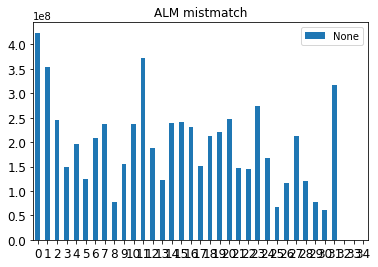

In [8]:
#original ALM

for item in assetList: #there is a better way than loop but its easier to understand
    iniAlm=iniAlm.add(item.cashFlowsUsdCurrent*item.weight,fill_value=0)
iniAlm=iniAlm.add(-liability.cashFlowsUsdCurrent,fill_value=0)

iniAlm[:35].plot.bar(title ="ALM mistmatch",rot=0,legend=True, fontsize=12)


In [9]:
#enter value for the gradient solver 
startTime=time.time()
weightDict,costFunction=gradientSolver(assetList,liability,nbIter=40,flatDiscount=0.03,halfRate=50,minLearnRate=0.001,learningRate=0.1,randomize=False)
print("--- %s seconds ---" % (time.time() - startTime))


--- 5.860116958618164 seconds ---


In [10]:
for asset in assetList:
    asset.weight=weightDict[asset.isin]

## Final results 

AxesSubplot(0.125,0.125;0.775x0.755)


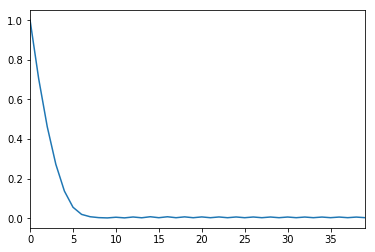

In [11]:
print(pd.Series(costFunction/costFunction[0]).plot.line())
#As you can see it show a 90%+ improvement

In [12]:
#you can output the dictionary to a file if you want the print is just to show you
#print(weightDict)
print('percentage improvement = {:.4%}'.format(1-costFunction[-1]/costFunction[0]))

percentage improvement = 99.7353%


AxesSubplot(0.125,0.125;0.775x0.755)


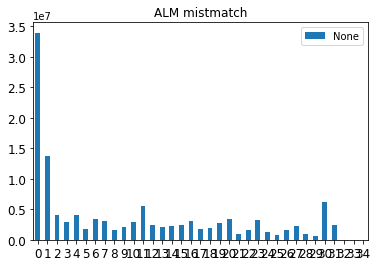

In [13]:
finALm=iniAlm*0
for item in assetList: #there is a better way than loop but its easier to understand
    finALm=finALm.add(item.cashFlowsUsdCurrent*item.weight,fill_value=0)
finALm=finALm.add(-liability.cashFlowsUsdCurrent,fill_value=0)
#final ALM
print(finALm[:35].plot.bar(title ="ALM mistmatch",rot=0,legend=True, fontsize=12))

In [114]:


#Save asset weights
with open(r'c:\test.csv', 'w') as f:
    for key in weightDict.keys():
        f.write("%s,%s\n"%(key,weightDict[key]))